In [2]:
import re
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['font.family']= 'open sans'
from matplotlib import colormaps
from matplotlib.colors import LinearSegmentedColormap

from rdn.fitting.pipeline import *
from rdn.fitting.models import LocalGaussModelTilde, MultiInterface
from rdn.fitting.losses import *
from rdn.fitting.visualize import *
from pypesto import visualize

from statsmodels.stats.diagnostic import normal_ad

Import fitting and sampling results

In [3]:
model = LocalGaussModelTilde()
multi_interface = MultiInterface(model)
loss_fn = NLLAdast()
n_starts = 1200

nsss = [1,3,5,7]


## Optimization ####
problem = setup_multi_pypesto_problem(
    nsss,
    multi_interface,
    loss_fn,
    plot_data=False
)

result = optimize_multi_problem(
    nsss,
    multi_interface,
    loss_fn,
    problem,
    n_starts,
    mode='multi_fitting',
    force_optimization=False,
)

result_sampling = read_from_hdf5.read_result(
    filename=f'output/sampling/sample_APTAM_100000.hdf5',
    problem=True,
    sample=True
)

ress_a = result.optimize_result[0:437]


Result already present, using old one with same parameters


# Figure S2

In [4]:
par_names = problem.x_names
best_res = result.optimize_result.x[0]

# Take the optimized basal k and n distributions (log 10)
best_log10_kb = np.array([kb for kb, parname in zip(best_res, par_names) if '_Kb' in parname])
best_log10_nb = np.array([nb for nb, parname in zip(best_res, par_names) if '_Nbo' in parname])

# Transform into normal log
best_log_kb = best_log10_kb * np.log(10)
best_log_nb = best_log10_nb * np.log(10)

# Add omega and dendritic length
best_log_kb += np.log(5000*1000)
best_log_nb += np.log(5000)

In [5]:
def call_colors(arr, eps=1e-2, reps=1.1):
    colors = [0]
    for i in range(1,len(arr)):
        if arr[i]/(arr[i-1]+1e-8) > reps \
            and arr[i]-arr[i-1] > eps: 
                colors.append(colors[-1]+1)
        else: colors.append(colors[-1])

    return np.array(colors)


def custom_stripplot(ax, data, colors, **kwargs):

    jitter = 0.5

    for x, (d, c) in enumerate(zip(data, colors)):
        x = np.array([x]*len(d)) + (np.random.rand(len(d))-0.5)*jitter
        ax.scatter(x, d, color=c, **kwargs)

    ax.set_xticks(range(len(data)))
    ax.set_ymargin(0.5)




def plot_cascade(ax, result, eps, reps):

    fvals = []

    for optr in result.optimize_result:
        fvals.append(optr['fval'])

    y_offset = np.array(fvals).min()


    fvals = np.array(fvals) - y_offset
    X = np.arange(len(fvals))

    colors = call_colors(fvals, eps=eps, reps=reps)

    colors = np.where(colors==0, 1, 0)

    c1, c2 = ['gray', 'tab:blue']
    inset_cmap = LinearSegmentedColormap.from_list('inset_cmap', [c1, c2])
    ax.scatter(X, fvals, s=20, c=colors, cmap=inset_cmap)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.ticklabel_format(axis='x', style='plain')
    ax.set_xlabel('Run index')

    # ax.set_yscale('log')
    ax.set_ylabel(f'Criterion value\n(offset {y_offset:.2f})')


    # Inset with limits
    x1, x2, y1, y2 = int(0), int(1080), 0, .12
    axi = ax.inset_axes(
        [0.2,0.4,0.5,0.5],
        xlim=(x1, x2), ylim=(y1,y2))

    fvals_inset = []

    for optr in result.optimize_result[x1:x2+1]:
        fvals_inset.append(optr['fval'])


    X_inset = np.arange(x1, x2+1)
    fvals_inset = np.array(fvals_inset) - y_offset

    colors = call_colors(fvals_inset)
    colors = np.where(colors==0, 1, 0)

    axi.scatter(X_inset, fvals_inset, s=20, c=colors, cmap=inset_cmap)
    ax.indicate_inset_zoom(axi, edgecolor='black')

    axi.spines['top'].set_visible(True)
    axi.spines['right'].set_visible(True)
    axi.set_xticks([437])
    axi.set_yticks([0, .1])

    axi.text(220, 0.032, 'LM1', fontsize=12, ha='center')
    axi.text(770, 0.065, 'LM2', fontsize=12, ha='center')


def plot_tau_difference(axs, result):

    ax = axs[0]

    fvals = []

    for optr in result.optimize_result:
        fvals.append(optr['fval'])

    fvals = np.array(fvals)

    colors = call_colors(fvals-fvals.min(), eps=1e-2, reps=1.2)
    min_a, max_a = np.where(colors==0)[0][[0,-1]]
    min_b, max_b = np.where(colors==1)[0][[0,-1]]

    ress_a = result.optimize_result.as_list()[min_a:max_a+1]
    ress_b = result.optimize_result.as_list()[min_b:max_b+1]

    tau_K_a = np.array([10**res.x[1] for res in ress_a])
    tau_K_b = np.array([10**res.x[1] for res in ress_b])

    custom_stripplot(ax, [tau_K_a, tau_K_b], [c2, c1], \
        marker='o', linewidths=0, alpha=0.1, edgecolor='white', s=20)

    ax.scatter((0,1),
               (np.median(tau_K_a), np.median(tau_K_b)),
               marker='_',
               s=100,
               c='black'
    )

    ax.set_xticks([])
    ax.set_ylabel(r'$\tau_K$ [min]')



    ax = axs[1]

    tau_N_a = np.array([10**res.x[4] for res in ress_a])
    tau_N_b = np.array([10**res.x[4] for res in ress_b])

    custom_stripplot(ax, [tau_N_a, tau_N_b], [c2, c1], \
        marker='o', linewidths=0, alpha=0.1, edgecolor='white', s=20)

    ax.scatter((0,1),
               (np.median(tau_N_a), np.median(tau_N_b)),
               marker='_',
               s=100,
               c='black'
    )

    ax.set_xticklabels(['LM 1', 'LM 2'], rotation=90)
    ax.set_ylabel(r'$\tau_N$ [min]')

    for ax in axs:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        
        ax.set_xlim(-1,2)


def plot_lognormality_histogram(axs, result, test_for_normality):

    fvals = []

    for optr in result.optimize_result:
        fvals.append(optr['fval'])

    fvals = np.array(fvals)

    colors = call_colors(fvals-fvals.min(), eps=1e-2, reps=1.2)
    min_a, max_a = np.where(colors==0)[0][[0,-1]]
    min_b, max_b = np.where(colors==1)[0][[0,-1]]

    ress_a = result.optimize_result.as_list()[min_a:max_a+1]
    ress_b = result.optimize_result.as_list()[min_b:max_b+1]


    kb_idx = [i for i, parname in enumerate(par_names) if '_Kb' in parname]
    nb_idx = [i for i, parname in enumerate(par_names) if '_Nbo' in parname]

    k_dag_good = 0
    n_dag_good = 0

    kps = []
    nps = []

    kbss = []
    nbss = []

    for res in ress_a:
        kbs = res.x[kb_idx]

        nbs = res.x[nb_idx]

        _, p = test_for_normality(kbs)
        if p >= 0.05: k_dag_good +=1 
        kps.append(p)

        _, p = test_for_normality(nbs)
        if p >= 0.05: n_dag_good +=1 
        nps.append(p)

        kbss.append(kbs)
        nbss.append(nbs)


    ax = axs[0]
    _, __, patches = ax.hist(kps, bins=50, histtype='step', density=True, color=c2)


    # Half fill the histogram
    verts = np.concatenate([
        patches[0].get_path().vertices[np.where(patches[0].get_path().vertices[:,0]>0.045)],
        np.array([0.05,0]).reshape(1,2)
    ])

    ax.add_patch(plt.Polygon(verts, color=c2))

    ax.axvline(x=0.05, linewidth=1, linestyle='--', c='black')

    ax.annotate(
        text=f'Lognormal compatible\nfraction: {k_dag_good/len(ress_a)*100:.0f}%',
        xy=(0.15, 0.6),
        xycoords='axes fraction',
    )

    ax.set_xmargin(0.02)
    ax.set_xticks([0.05], ['0.05'])
    ax.set_xlabel(
        r"Anderson Darling p-values ($K_b$)", 
        labelpad=-11, 
        fontsize=10,
        # loc='right'
    )

    ax.set_yticks([])
    ax.set_ylabel('counts')
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    ax = axs[1]
    _, __, patches = ax.hist(nps, bins=50, histtype='step', density=True, color=c2)

    # Half fill the histogram
    verts = np.concatenate([
        patches[0].get_path().vertices[np.where(patches[0].get_path().vertices[:,0]>0.045)],
        np.array([0.05,0]).reshape(1,2)
    ])
    ax.add_patch(plt.Polygon(verts, color=c2))
    ax.axvline(x=0.05, linewidth=1, linestyle='--', c='black')

    ax.annotate(
        text=f'Lognormal compatible\nfraction: {n_dag_good/len(ress_a)*100:.0f}%',
        xy=(0.15, 0.6),
        xycoords='axes fraction',
    )

    ax.set_xmargin(0.02)
    ax.set_xticks([0.05], ['0.05'])
    ax.set_xlabel(
        r"Anderson Darling p-values ($N_b$)",
        labelpad=-11,
        fontsize=10,
        # loc='right',
    )

    ax.set_yticks([])
    ax.set_ylabel('counts')
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


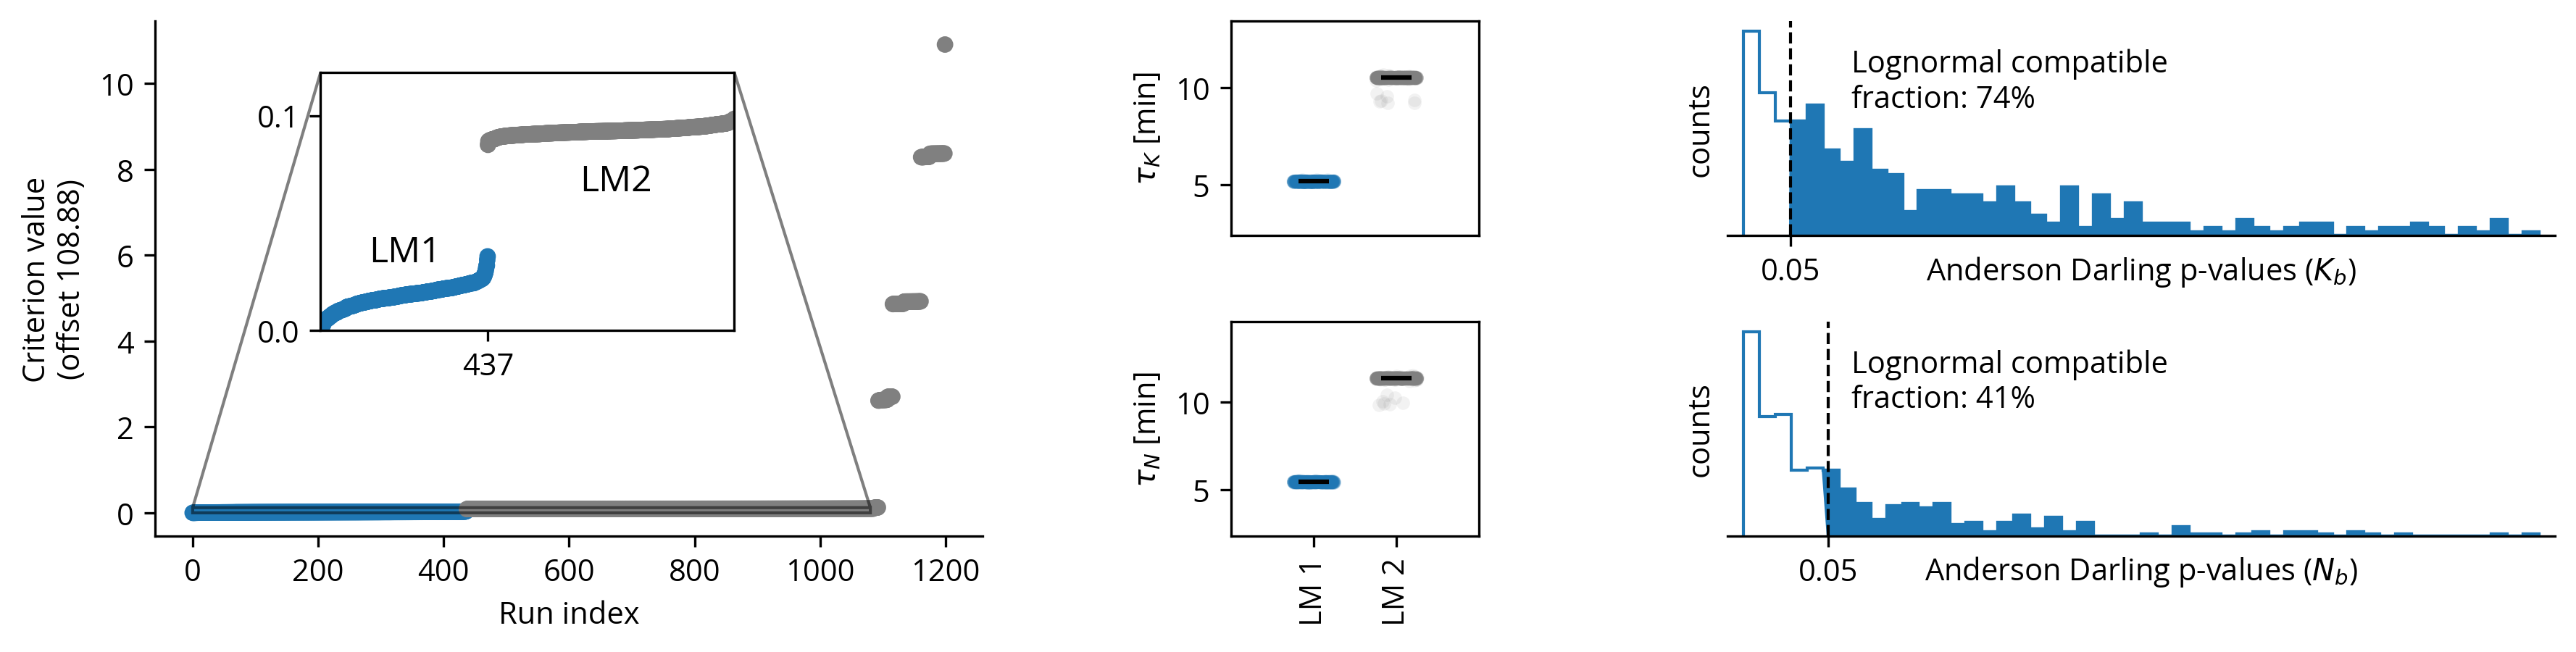

In [6]:
lb, ub = result.problem.lb_full, result.problem.ub_full


# Upper panel
fig = plt.figure(figsize=(12,3), dpi=300)
gs = fig.add_gridspec(2,5, width_ratios=(1,.1,.3,.1, 1))
fig.subplots_adjust(hspace=0.4, left=0.06, right=0.98, top=0.99, bottom=0.2)

annotation_axs = []

c1, c2 = colormaps['Set2'].colors[:2];
c1, c2 = ['gray', 'tab:blue']
inset_cmap = LinearSegmentedColormap.from_list('inset_cmap', [c1, c2])

ax = fig.add_subplot(gs[:,0])
annotation_axs.append(ax)

plot_cascade(ax, result, eps=1e-2, reps=1.2)

axu = fig.add_subplot(gs[0,2])
annotation_axs.append(ax)
axd = fig.add_subplot(gs[1,2])
plot_tau_difference([axu, axd], result)

axu = fig.add_subplot(gs[0,4])
annotation_axs.append(ax)
axd = fig.add_subplot(gs[1,4])
plot_lognormality_histogram([axu, axd], result, normal_ad)

# plt.savefig('docs/figures-paper/supplementary/fit_evaluation.png')


# Figure S3, S4

/home/janko/code/phd/rdn-project/test-env/lib/python3.13/site-packages/rdn/fitting/visualize.py:349: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=(0.1,1))


RMSE = 1034.6768130384062
RRMSE = 0.0972639631733619


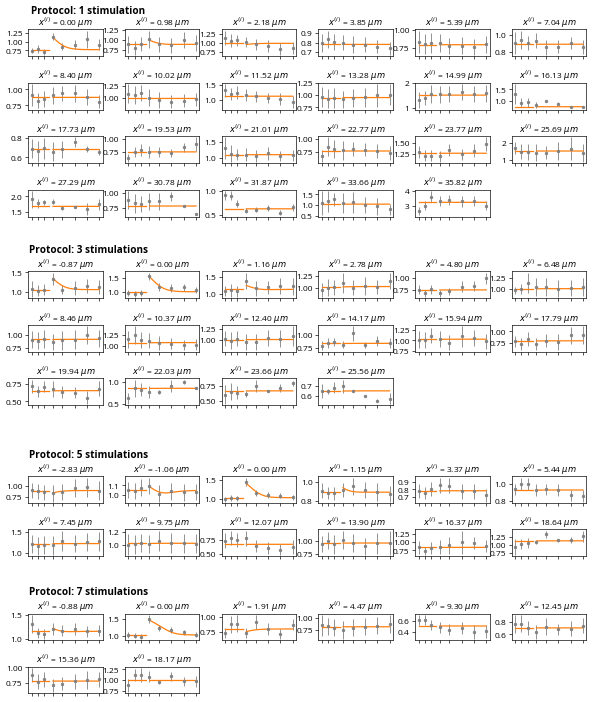

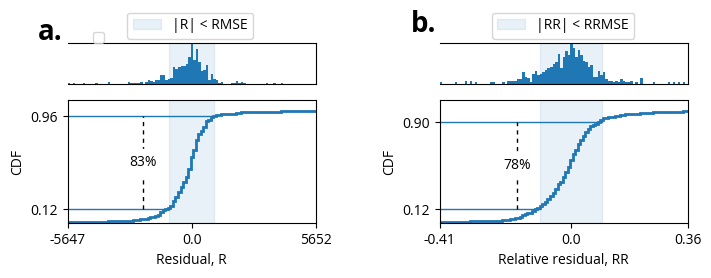

In [7]:
plot_paper_predictions(
    nsss,
    multi_interface,
    result,
    0,
    # save_path='./'
)

plt.show()

# Figure S5

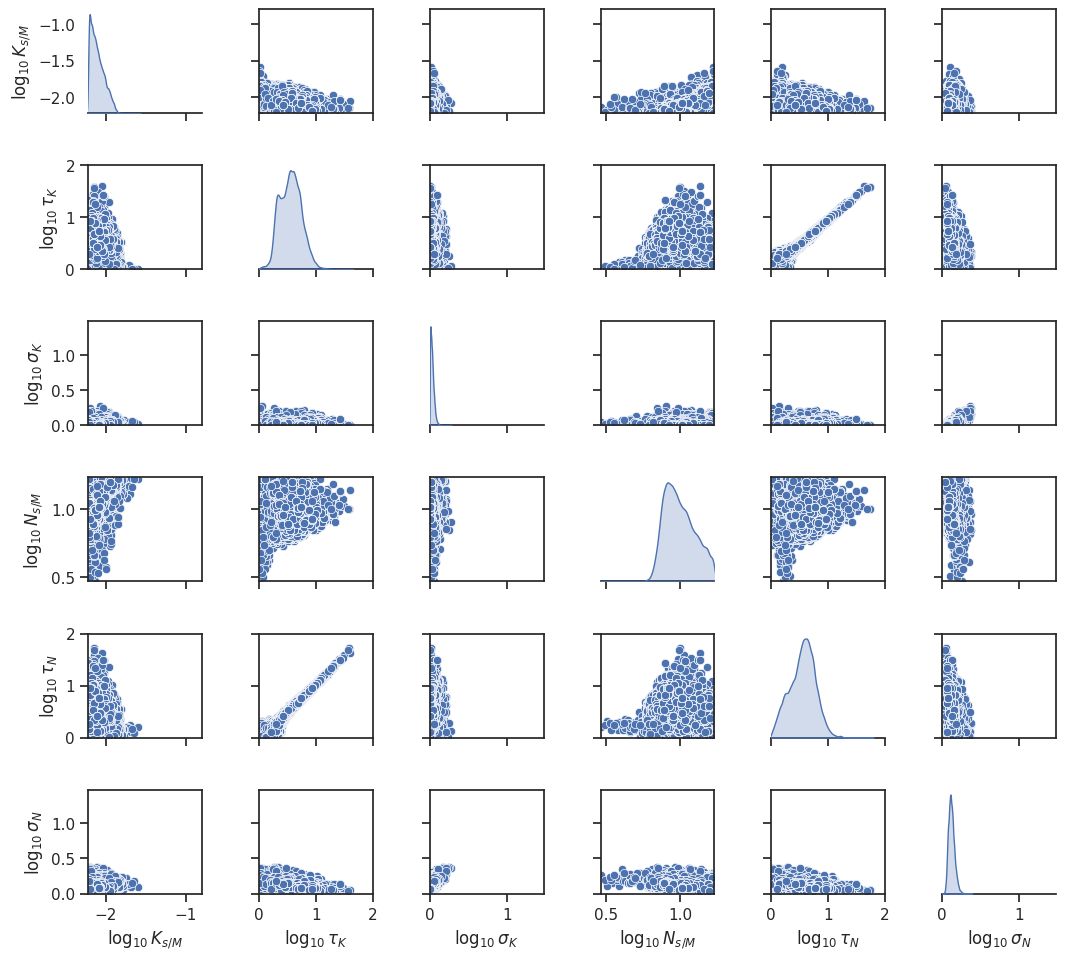

In [8]:
axs = visualize.sampling_scatter(result_sampling, size=(11, 10)).axes

for i, j in product(range(6), range(6)):
    if i!=j:
        axs[i,j].spines['top'].set_visible(True)
        axs[i,j].spines['right'].set_visible(True)

    else:
        axs[i,j].spines['left'].set_visible(False)
        axs[i,j].tick_params(axis='y', width=0)

labels = [
    r'$\log_{10}K_{s/M}$',
    r'$\log_{10}\tau_K$',
    r'$\log_{10}\sigma_K$',
    r'$\log_{10}N_{s/M}$',
    r'$\log_{10}\tau_N$',
    r'$\log_{10}\sigma_N$',
]

for ax, label in zip(axs[:,0], labels): ax.set_ylabel(label)
for ax, label in zip(axs[-1], labels): ax.set_xlabel(label)

fig = plt.gcf()
fig.subplots_adjust(wspace=0.5, hspace=0.5, left=0.1, bottom=0.1)

# Save the figure in case you need it
# plt.savefig('docs/figures-paper/supplementary/posteriors.png', dpi=300)

plt.show()

# Figure S6

In [9]:
par_names = result.problem.x_names

def parse_par_names(par_names):

    ppar_names = par_names.copy()

    for i, pn in enumerate(par_names):
        
        if 'KsoONbl' in pn: ppar_names[i] = r'$K_{s/7}$'
        if 'NsoNbl' in pn: ppar_names[i] = r'$N_{s/7}$'
        
        m = re.search(r'tau_([KN])', pn)
        if m: ppar_names[i] = r'$\tau_{}$'.format(m.group(1))

        m = re.search(r'sigma_([KN])', pn)
        if m: ppar_names[i] = r'$\sigma_{}$'.format(m.group(1))

        m = re.search(r'(\d+)_OoOl', pn)
        if m: ppar_names[i] = r'$\Omega_{{{}/7}}$'.format(m.group(1))

        m = re.search(r'(\d+)_Pi', pn)
        if m: ppar_names[i] = r'$\Pi_{{{}}}$'.format(m.group(1))

        m = re.search(r'(\d+)_KboONbl_(.+)', pn)
        if m: ppar_names[i] = r'$K_{{{}/7}}^{{{}}}$'.format(m.group(1), m.group(2))

        m = re.search(r'(\d+)_NboNbl_(.+)', pn)
        if m: ppar_names[i] = r'$N_{{{}/7}}^{{{}}}$'.format(m.group(1), m.group(2))
        # m = re.search()

    return ppar_names


ppar_names = parse_par_names(par_names)


<>:59: SyntaxWarning: invalid escape sequence '\}'
<>:59: SyntaxWarning: invalid escape sequence '\}'
/tmp/ipykernel_10874/1254328.py:59: SyntaxWarning: invalid escape sequence '\}'
  distance = float(re.search('\}\^\{(-?\d+.\d+)', pn)[1])


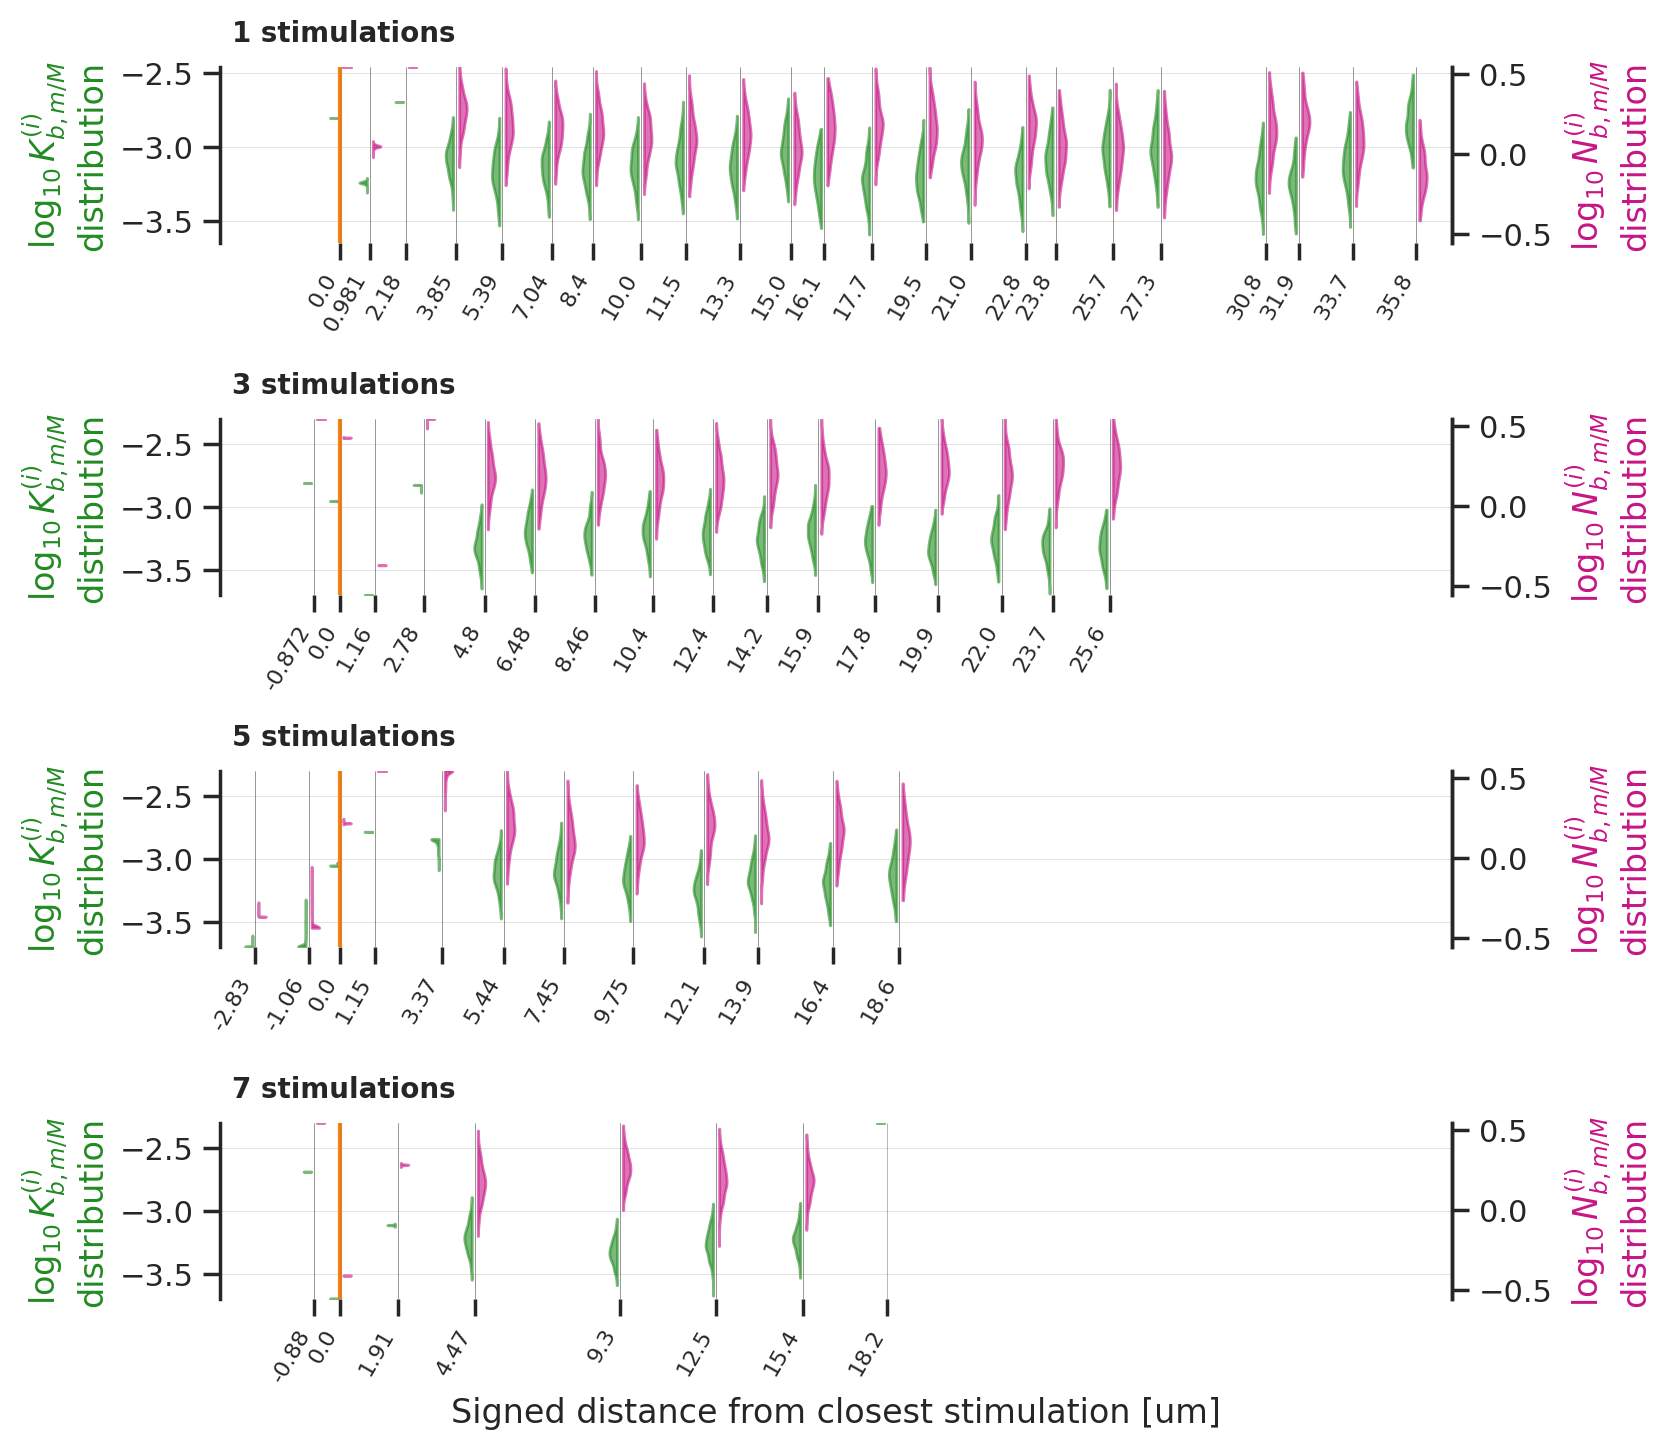

In [10]:
fig, axs = plt.subplots(4,1, dpi=200, figsize=(8,8))
fig.subplots_adjust(hspace=1, left=0.11, right=0.88)

par_names = result.problem.x_names

row = 0

N_or_K = 'K'
side = 'low'
ax = axs[0]
color='forestgreen'
offset = -0.1

log_bc = {
    'K' : [np.log10(0.0002), np.log10(0.005)],
    'N' : [np.log10(0.28), np.log10(3.5)], 
}

distances = []

for i, pn in enumerate(ppar_names):

    # Drop the non basal parameters
    if (
        not re.search(r'K_{\d', pn)
        and not re.search(r'N_{\d', pn)
    ): 
        # print(pn)
        continue

    # Change row if we switch protocol or catalyst
    if (pn[1] != N_or_K):
        if pn[1] == 'K':
            distances = []
            row += 1
            side = 'low'
            color = 'forestgreen'
            offset = -0.1
            ax = axs[row]
            ax.set_ylim(*log_bc['K'])
            ax.set_ylabel(r'$\log_{10} K^{(i)}_{b,m/M}$'+ '\ndistribution', color='forestgreen')

        else:
            side = 'high'
            color = 'mediumvioletred'
            offset=0.1
            ax.set_xticks(distances, distances, rotation=60, fontsize=8, ha='right')
            ax=axs[row].twinx()
            for k, sp in ax.spines.items():
                if k != 'right': sp.set_visible(False)

            ax.set_ylim(*log_bc['N'])
            ax.set_ylabel(r'$\log_{10} N^{(i)}_{b,m/M}$'+ '\ndistribution', color='mediumvioletred')

        N_or_K = pn[1]


    try:
        distance = float(re.search('\}\^\{(-?\d+.\d+)', pn)[1])
    except:
        raise ValueError(pn)

    distances.append(distance)


    log_par = []
    for res in ress_a:
        log_par.append(res.x[i])

    log_par = np.array(log_par)

    violin_parts = ax.violinplot(
        log_par, 
        positions=(distance+offset,),
        showextrema=False,
        side=side
    )

    for pc in violin_parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(0.6)

    ax.axvline(x=distance, linewidth=0.2, c='gray')
    
    

axs[0].set_ylabel(r'$\log_{10} K^{(i)}_{b,m/M}$' + '\ndistribution', color='forestgreen')
axs[-1].set_xlabel('Signed distance from closest stimulation [um]')

nsss = [1,3,5,7]

for i, ax in enumerate(axs):
    ax.set_title(f'{nsss[i]} stimulations', x=0.1, y=1.05, fontsize=10, fontweight='bold')
    ax.axvline(x=0, c='tab:orange')
    ax.set_xlim(-4, 37)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(.2)
    ax.spines['top'].set_linewidth(.2)
    ax.grid(axis='y', linewidth=0.2)

# for ax in axs[row, col:]: ax.remove()
# plt.savefig('docs/figures-paper/supplementary/basal-optima-distributions.png', dpi=300)
